In [1]:
# http://economics.fundamentalfinance.com/game-theory/nash-equilibrium.php

In [4]:
from MWU import Sto_Game
# import pandas as pd

# Helper functions

In [3]:
class Game:    
    def __init__(self, action_list, cost_list):
        self.cost_list = cost_list
        self.agent_actions = self.initialize_actions(action_list)
        self.agent_weights = self.initialize_weights(self.agent_actions)
        All_Strategy = list(product(*[i for i in action_list]))
        self.action_to_cost = self.initialize_actions_cost(All_Strategy, cost_list)
        
    def initialize_weights(self,agent_actions_dict):
        agent_weights = {}
        for agent_name,strategy in agent_actions_dict.items():
            agent_weights[agent_name] = np.ones(len(strategy))+np.array([0.2,0.1])
#             agent_weights[agent_name] = np.array([1,2])
        return agent_weights

    
    def initialize_actions(self,agent_actions_list):
        agent_actions = {}
        agent_counter = 1
        for actions in agent_actions_list:
            agent_actions['agent{}'.format(agent_counter)] = actions
            agent_counter +=1
        return agent_actions        

    def initialize_actions_cost(self,All_Strategy, cost_list):
        """cost_list should be input row by row"""
        action_to_cost = {}
        flat_cost_list = [item for sublist in cost_list for item in sublist]
        for strategy, cost in zip(All_Strategy,flat_cost_list):
            action_to_cost[strategy] = cost
        return action_to_cost

    def action(self,probability_distribution):
        return np.random.choice(len(probability_distribution),1,p=probability_distribution)[0] # [0] unwarp the array

    def get_action(self,agent, agent_weights):
        total = sum(agent_weights[agent])
        num_actions = len(agent_weights[agent])
        agent_p = [agent_weights[agent][i]/total for i in range(num_actions)]
        debug_agent_p1 = agent_weights[agent][1]/total
        agent_a = self.action(agent_p)
    #     print('probability of action1 = {}'.format(agent_p))
    #     print('probability of action2 = {}'.format(debug_agent_p1))
    #     print(agent_weights[agent])

        return agent_a    

    def get_cost_vector(self,agent, opponent_action, agent_actions, action_to_cost):
        num_actions = len(self.agent_actions[agent])
        cost_vector = []
        if agent == 'agent1':
            action_vector = [tuple([agent_actions['agent1'][i],agent_actions['agent2'][opponent_action]]) for i in range(num_actions)]
    #         print("agent 1's action = {}".format(action_vector))
            for a in action_vector:
                cost_vector.append(action_to_cost[a][0]) # 0 means agent1
        else:
            num_actions = len(agent_actions[agent])
            action_vector = [tuple([agent_actions['agent1'][opponent_action],agent_actions['agent2'][i]]) for i in range(num_actions)]
    #         print("agent 2's action = {}".format(action_vector))
            cost_vector = []
            for a in action_vector:
                cost_vector.append(action_to_cost[a][1])
        return np.array(cost_vector)
    def print_game(self):
        pass
        
    def MWU(self,iterations, epsilon=0.05, new_ep=lambda ep, t: ep):  
        num_actions1 = len(self.agent_weights['agent1'])
        num_actions2 = len(self.agent_weights['agent2'])
        
        agent1_sum = sum(self.agent_weights['agent1'])
        agent2_sum = sum(self.agent_weights['agent2'])

        self.agent1_history = [[self.agent_weights['agent1'][i]/agent1_sum for i in range(num_actions1)]]
        self.agent2_history = [[self.agent_weights['agent2'][i]/agent2_sum for i in range(num_actions2)]]

        counter = 1
        for i in range(iterations):
    #         print('playing game round {}'.format(counter))
            agent1_a = self.get_action('agent1',self.agent_weights)
            agent2_a = self.get_action('agent2',self.agent_weights)
#             print("weight vector = ",self.agent_weights['agent1'])

            cost_vector1 = self.get_cost_vector('agent1', agent2_a, self.agent_actions, self.action_to_cost)
#             print("cost_vector1 = ",cost_vector1)
            cost_vector2 = self.get_cost_vector('agent2', agent1_a, self.agent_actions, self.action_to_cost)
            epsilon = new_ep(epsilon, i+1)
            self.agent_weights['agent1'] = self.agent_weights['agent1']*(1-epsilon)**cost_vector1
            self.agent_weights['agent2'] = self.agent_weights['agent2']*(1-epsilon)**cost_vector2    

            agent1_sum = sum(self.agent_weights['agent1'])
            agent2_sum = sum(self.agent_weights['agent2'])

            self.agent1_history.append([self.agent_weights['agent1'][i]/agent1_sum for i in range(num_actions1)])
            self.agent2_history.append([self.agent_weights['agent2'][i]/agent2_sum for i in range(num_actions2)])


            counter+=1
        print("Training for {} steps is done".format(counter-1))
#         print('outputing {} strategies for agent1'.format(num_actions1))
#         print('outputing {} strategies for agent2'.format(num_actions2))
#         return self.agent1_history, self.agent2_history
    def plot(self):
        fontsize = 16
        fontsize_title = 20
        fig, ax = plt.subplots(1,2,figsize=(16,5))
        ax[0].set_title('agent1', fontsize=fontsize_title)
        ax[1].set_title('agent2', fontsize=fontsize_title)
        ax[0].set_xlabel('step', fontsize=fontsize)
        ax[1].set_xlabel('step', fontsize=fontsize)
        ax[0].set_ylabel('Probability of choosing certain action', fontsize=fontsize)
        ax[1].set_ylabel('Probability of choosing certain action', fontsize=fontsize)    

        ax[0].plot(self.agent1_history)
        ax[1].plot(self.agent2_history)
        print(len(self.agent1_history))
        print(len(self.agent2_history))

        ax[0].legend([s for s in self.agent_actions['agent1']])
        ax[1].legend([s for s in self.agent_actions['agent2']])
        
    def show_game(self):
        return pd.DataFrame(self.cost_list,columns=self.agent_actions['agent2'], index=self.agent_actions['agent1'])
    #     agent_weights['agent1'][0]/agent1_sum, agent_weights['agent1'][1]/sum(agent_weights['agent1']), agent_weights['agent2'][0]/sum(agent_weights['agent2']), agent_weights['agent2'][1]/sum(agent_weights['agent2'])
    def get_history(self):
#         print(len(self.agent1_history))
#         print(len(self.agent2_history))
        return [self.agent1_history, self.agent2_history]
    
    def plot_scatter(self):
            plt.figure(figsize=(8,8))
            plt.scatter(np.array(self.agent1_history)[:,0], np.array(self.agent2_history)[:,0])
            plt.xlim(0,1)
            plt.ylim(0,1)

## Multiplicative Weight Update Algorithm

$$\huge w^{t+1}(a) = w^t(a)(1-\epsilon)^{c^t(a)}$$

# $\epsilon=0.5$

Training for 2500 steps is done
2501
2501


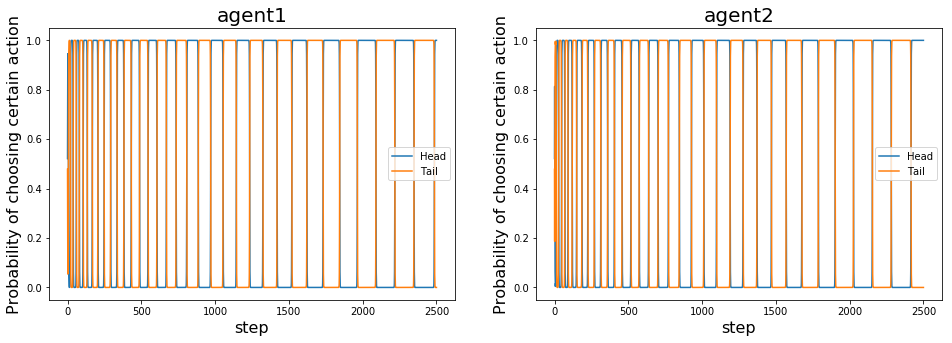

In [9]:
action_list = [['Head', 'Tail'],['Head', 'Tail']]
cost_list = [[[-1,1],[1,-1]],[[1,-1],[-1,1]]]
Matching = Sto_Game(action_list, cost_list)

Matching.MWU(2500,0.5)
Matching.plot()

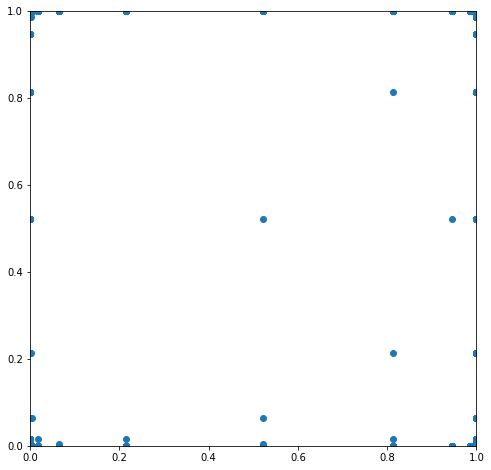

In [10]:
Matching.plot_scatter()

# $\epsilon=\frac{1}{t^{1/3}}$

Training for 2500 steps is done
2501
2501


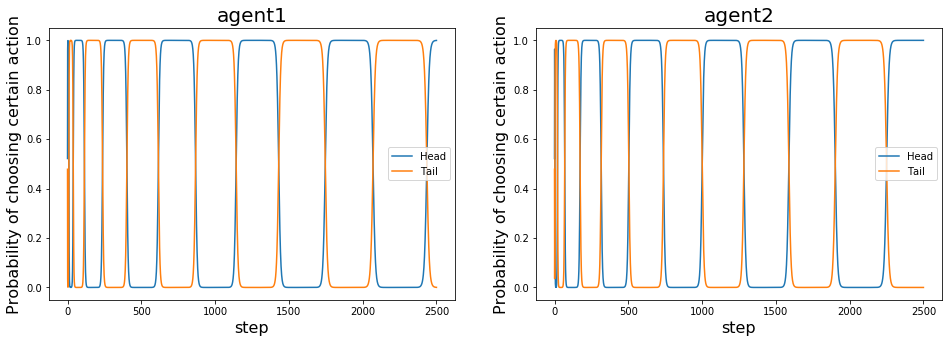

In [11]:
action_list = [['Head', 'Tail'],['Head', 'Tail']]
cost_list = [[[-1,1],[1,-1]],[[1,-1],[-1,1]]]
Matching = Sto_Game(action_list, cost_list)
history = Matching.MWU(2500, new_ep=lambda ep, t:0.8/t**(1/3))
Matching.plot()

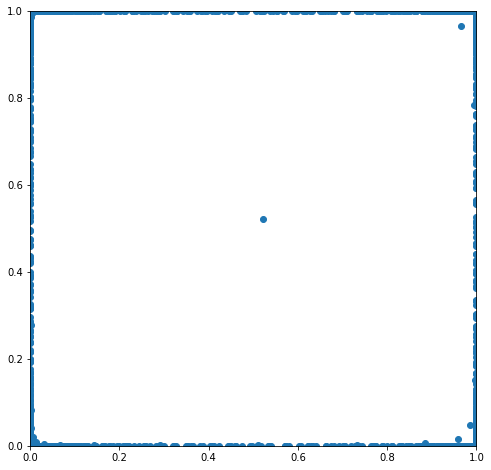

In [12]:
Matching.plot_scatter()

# $\epsilon=\frac{1}{t^{1/2}}$

Training for 2500 steps is done
2501
2501


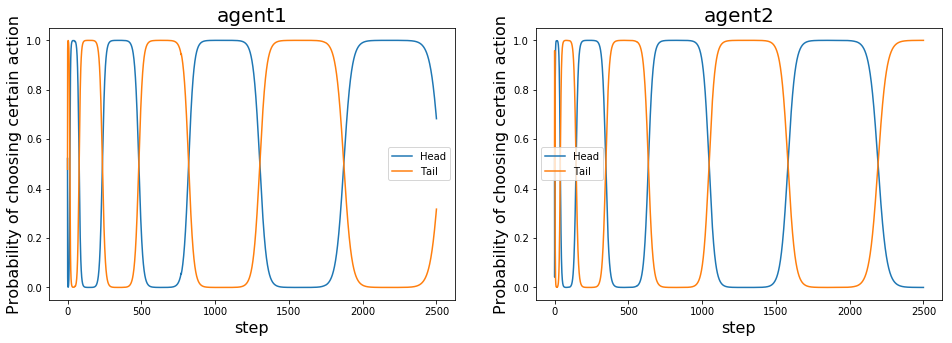

In [13]:
action_list = [['Head', 'Tail'],['Head', 'Tail']]
cost_list = [[[-1,1],[1,-1]],[[1,-1],[-1,1]]]
Matching = Sto_Game(action_list, cost_list)
history = Matching.MWU(2500, new_ep=lambda ep, t:0.8/t**(1/2))
Matching.plot()

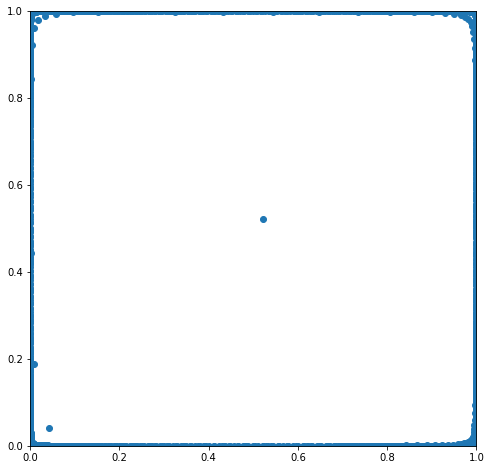

In [14]:
Matching.plot_scatter()

# $\epsilon=\frac{1}{t^{2/3}}$

Training for 2500 steps is done
2501
2501


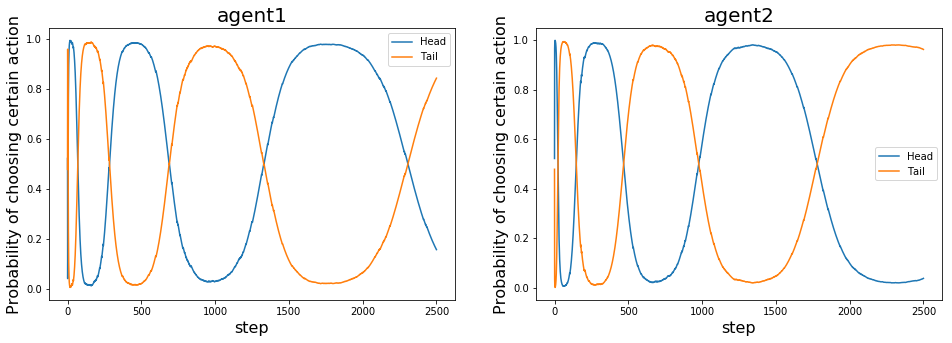

In [23]:
action_list = [['Head', 'Tail'],['Head', 'Tail']]
cost_list = [[[-1,1],[1,-1]],[[1,-1],[-1,1]]]
Matching = Sto_Game(action_list, cost_list)
history = Matching.MWU(2500, new_ep=lambda ep, t:0.8/t**(2/3))
Matching.plot()

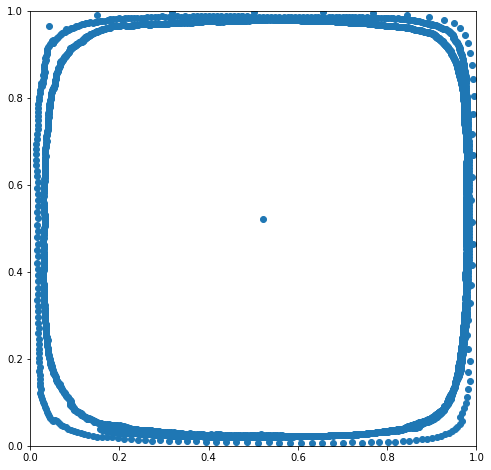

In [24]:
Matching.plot_scatter()